## Water level extraction from tidal models

In this script, we calculate tidal predictions for a site of interest using the FES2022 tidal model. Data is saved in the `Data/sitename/tide` folder. 
The model is available from the AVISO website and is described in these works:

> Carrere et al., OSTST 2022: A new barotropic tide model for global ocean: FES2022,
https://doi.org/10.24400/527896/a03-2022.3287

> Florent H. Lyard, Loren Carrere, Ergane Fouchet, Mathilde Cancet, David Greenberg, Gérald Dibarboure and Nicolas Picot: “FES2022 a step towards a SWOT-compliant tidal correction”, to be submitted to Ocean Sciences.

The FES2022 model can be downloaded (upon registration) from the [Aviso+ website](https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes.html) and should be placed in the `FES2022` folder, within the project folder.  

First, we import the libraries needed for the prediction

In [1]:
from astropy.time import Time, TimeDelta
import pandas as pd
import datetime
import pyTMD
import pyTMD.io
import pyTMD.time
import pyTMD.predict
import pyTMD.tools
import pyTMD.utilities
import os
import numpy as np
import timescale.time
import datetime
import pytz
import matplotlib.pyplot as plt

A number of inputs is required to run the code. First, select the point where data should be extracted on an interactive map

In [2]:
from coastsat.CSatVe_Tide_select import create_map

# Create the map and get helper functions
map_widget, output_widget, saved_variables, get_map_bounds = create_map()

In [3]:
#Save LAT and LON for successive use
LAT=saved_variables["LAT"]
LON=saved_variables["LON"]
print("Latitude and Longitude:", saved_variables["LAT"], saved_variables["LON"])

Latitude and Longitude: -46.53715579888858 -67.441463470459


Then, define the name of the model (default is FES2022), and the sitename

In [4]:
# name of the site
sitename = 'Caleta_Olivia' #Please use underscore instead of space

# insert the version of FES you are using (default is FES2022)
MODEL_NAME='FES2022'

# Insert the folder where the data is located and the coordinates at which you want to extrapolate the tidal data
folder='TidalModel/FES2022/'

# directory where the data will be stored
filepath = os.path.join(os.getcwd(), 'Data')

# create folder to save outputs from tidal data
folder_tides = os.path.join(filepath,sitename,'water_levels')
if not os.path.exists(folder_tides):
    os.makedirs(folder_tides)

Define the start and end date for the tidal prediction and the interval for the water levels. Default is 10 minutes.
Times should be defined as `yyyy,mm,dd,hh,mm,ss`. We suggest to leave hours, minutes and seconds to 00 as default.

In [5]:
# Define start and end date
start_date = datetime.datetime(1980, 1, 1, 00, 00, 00, tzinfo=pytz.UTC)
end_date = datetime.datetime(2024, 10, 31, 00, 00, 00, tzinfo=pytz.UTC)

# Time interval for water level extraction
interval_tide = 10 #minutes

Then, water levels are calculated. This cell takes a long time to run, depending on the time reported above.

In [6]:
current_path = os.getcwd()
full_path = os.path.join(current_path, folder)
model = pyTMD.io.model(full_path,format='netcdf',compressed=False).elevation(MODEL_NAME)

# Calculate the total number of 10-minute intervals between start and end dates
total_minutes = int((end_date - start_date).total_seconds() // 60)
interval_minutes = interval_tide
minutes = np.arange(0, total_minutes + interval_minutes, interval_minutes)

# Set the base date YMD to the start date
YMD = start_date.date()  # Using only the date part
# convert time from MJD to days relative to Jan 1, 1992 (48622 MJD)
ts = timescale.time.Timescale().from_calendar(YMD.year, YMD.month,
    YMD.day, minute=minutes)
hours = minutes/60.0

# delta time (TT - UT1) file
delta_file = pyTMD.utilities.get_data_path(['data','merged_deltat.data'])

constituents = pyTMD.io.FES.read_constants(model.model_file,
                                           type=model.type, version=model.version,
                                           compressed=model.compressed)
c = model.constituents
# delta time (TT - UT1)
DELTAT = ts.tt_ut1

amp,ph = pyTMD.io.FES.interpolate_constants(np.atleast_1d(LON), np.atleast_1d(LAT),
                                            constituents, scale=model.scale,
                                            method='spline', extrapolate=True)

# calculate complex phase in radians for Euler's
cph = -1j*ph*np.pi/180.0
# calculate constituent oscillation
hc = amp*np.exp(cph)
# predict tidal elevations at time and infer minor corrections
TIDE = pyTMD.predict.time_series(ts.tide, hc, c,
                                 deltat=DELTAT, corrections=model.corrections)
MINOR = pyTMD.predict.infer_minor(ts.tide, hc, c,
                                  deltat=DELTAT, corrections=model.corrections)
TIDE.data[:] += MINOR.data[:]

# Convert `ts` to a readable datetime format if it's not already
base_mjd = Time(YMD.isoformat(), format='iso', scale='utc').mjd  # MJD 
# Add minutes to your base MJD, converting minutes to days
mjd_times = base_mjd + (minutes / (24 * 60))  # Convert minutes to days
# Convert MJD to datetime for plotting
calendar_dates = Time(mjd_times, format='mjd', scale='utc').to_datetime()

# Create a DataFrame with the time and tide data
tides_df = pd.DataFrame({
    'DateTime': calendar_dates,
    'Tide': TIDE.data
})


The data is then saved in a `csv` file. Together with the data, we save in another file the location and start - end date information. A datafile that can be used as input in the [NOAA tidal datum calculator](https://access.co-ops.nos.noaa.gov/datumcalc/CalculateDatums) is also created. Then, a plot is made to show the tidal data.

Tide CSV file saved in /Users/alessiorovere/Dropbox/Mac/Documents/GitHub/CoastSat.Venice/Data/Caleta_Olivia/water_levels
Tide CSV file for NOAA saved in /Users/alessiorovere/Dropbox/Mac/Documents/GitHub/CoastSat.Venice/Data/Caleta_Olivia/water_levels
Metadata saved to /Users/alessiorovere/Dropbox/Mac/Documents/GitHub/CoastSat.Venice/Data/Caleta_Olivia/water_levels/FES2022_location_date_Caleta_Olivia.csv
Plot saved to /Users/alessiorovere/Dropbox/Mac/Documents/GitHub/CoastSat.Venice/Data/Caleta_Olivia/water_levels/Caleta_Olivia_tide_timeseries.jpg


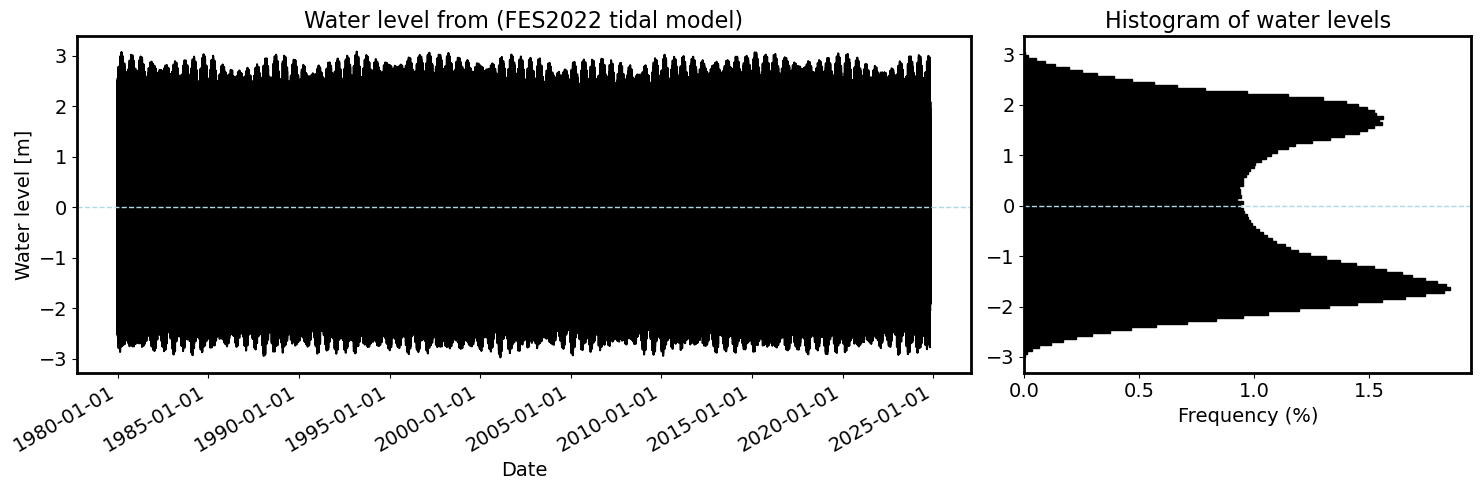

In [7]:
from coastsat.CSatVe_Save_Tide import process_and_save_tides

process_and_save_tides(calendar_dates, 
                       TIDE, 
                       LAT, 
                       LON, 
                       start_date, 
                       end_date, 
                       MODEL_NAME, 
                       sitename, 
                       folder_tides)

Now, you can use the tidal data in the following workflows.

## Acknowledgments
This code uses the FES2022 Tide product, which was funded by CNES, produced by LEGOS, NOVELTIS and CLS and made freely available by AVISO. CNES, 2024. FES2022 (Finite Element Solution) Ocean Tide (Version 2022) [Data set]. CNES. https://doi.org/10.24400/527896/A01-2024.004

- Carrere et al., OSTST 2022: A new barotropic tide model for global ocean: FES2022,
https://doi.org/10.24400/527896/a03-2022.3287

- Florent H. Lyard, Loren Carrere, Ergane Fouchet, Mathilde Cancet, David Greenberg, Gérald Dibarboure and Nicolas Picot: “FES2022 a step towards a SWOT-compliant tidal correction”, to be submitted to Ocean Sciences.

FES22 data are used herein under the terms of the [license agreement](https://www.aviso.altimetry.fr/fileadmin/documents/data/License_Aviso.pdf)

This code was written in the framework of the WARMCOASTS project, led by A. Rovere at Ca' Foscari University of Venice. This software is part of a project that has received funding from the European Research Council (ERC) under the European Union’s Horizon 2020 research and innovation programme (Grant agreement No. ERC-StG-802414)
